In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Cleaned Data ---
# This file was created by '01_data_preparation.ipynb'
DATA_FILE = 'df_model_cleaned.parquet'

try:
    df_model = pd.read_parquet(DATA_FILE)
    print("Cleaned data loaded successfully.")
    print(f"Total rows: {len(df_model)}, Total columns: {len(df_model.columns)}")
except FileNotFoundError:
    print(f"Error: The file {DATA_FILE} was not found.")
    print("Please run the first notebook '01_data_preparation.ipynb' to create it.")

# Check the data
print(df_model.head())
print("\n--- DataFrame Info ---")
df_model.info()

Cleaned data loaded successfully.
Total rows: 50282, Total columns: 25
                           AT_load_actual_entsoe_transparency  \
datetime                                                        
2015-01-05 22:00:00+00:00                              6182.0   
2015-01-05 23:00:00+00:00                              5523.0   
2015-01-06 00:00:00+00:00                              5220.0   
2015-01-06 01:00:00+00:00                              5015.0   
2015-01-06 02:00:00+00:00                              4868.0   

                           AT_solar_generation_actual  \
datetime                                                
2015-01-05 22:00:00+00:00                         0.0   
2015-01-05 23:00:00+00:00                         0.0   
2015-01-06 00:00:00+00:00                         0.0   
2015-01-06 01:00:00+00:00                         0.0   
2015-01-06 02:00:00+00:00                         0.0   

                           AT_wind_onshore_generation_actual  \
datetime 

In [17]:
# --- 2. Define Target (y) and Features (X) ---

# Build our first model to predict the load for France (FR)
TARGET_COLUMN = 'FR_load_actual_entsoe_transparency'

# 'y' is our target variable (what we want to predict)
y = df_model[TARGET_COLUMN]

# 'X' is our set of features (what we use to predict)
# It's all columns EXCEPT the target column
X = df_model.drop(columns=[TARGET_COLUMN])

print(f"Target (y) column: {y.name}")
print(f"Feature (X) columns (example): {list(X.columns[:5])}...")
print(f"Total features: {len(X.columns)}") # Should be 24

Target (y) column: FR_load_actual_entsoe_transparency
Feature (X) columns (example): ['AT_load_actual_entsoe_transparency', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual']...
Total features: 24


In [18]:
# --- 3. Train-Test Split (Time Series) ---

# We must train on the past and test on the future.
# We will use data before 2020 to train, and data from 2020 to test.

# Create the training set (all data before Jan 1, 2020)
X_train = X[X.index < '2020-01-01']
y_train = y[y.index < '2020-01-01']

# Create the test set (all data from Jan 1, 2020 onwards)
X_test = X[X.index >= '2020-01-01']
y_test = y[y.index >= '2020-01-01']

print("--- Data Split ---")
print(f"Training data points (X_train): {len(X_train)}")
print(f"Test data points (X_test): {len(X_test)}")
print(f"Training data starts: {X_train.index.min()}")
print(f"Training data ends: {X_train.index.max()}")
print(f"Test data starts: {X_test.index.min()}")
print(f"Test data ends: {X_test.index.max()}")

--- Data Split ---
Training data points (X_train): 43706
Test data points (X_test): 6576
Training data starts: 2015-01-05 22:00:00+00:00
Training data ends: 2019-12-31 23:00:00+00:00
Test data starts: 2020-01-01 00:00:00+00:00
Test data ends: 2020-09-30 23:00:00+00:00


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 4. Train First Model: Linear Regression (Baseline) ---

# Create an instance of the model
model_lr = LinearRegression()

# Train the model
print("Training the Linear Regression model...")
model_lr.fit(X_train, y_train)
print("Model trained successfully.")

# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test)

# 4. Evaluate the model's performance
# We compare the predictions (y_pred_lr) with the real values (y_test)
print("\n--- Model Evaluation (Test Set) ---")

# Mean Absolute Error (MAE): The average error in MW.
mae = mean_absolute_error(y_test, y_pred_lr)
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")

# Root Mean Squared Error (RMSE): Similar to MAE, but penalizes large errors more.
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")

# R-squared (R²): How much of the variation the model explains (1.0 = perfect)
r2 = r2_score(y_test, y_pred_lr)
print(f"R-squared (R²) Score: {r2:.4f}")

Training the Linear Regression model...
Model trained successfully.

--- Model Evaluation (Test Set) ---
Mean Absolute Error (MAE): 4052.58 MW
Root Mean Squared Error (RMSE): 5135.00 MW
R-squared (R²) Score: 0.7732



Plotting first week of 2020 predictions...


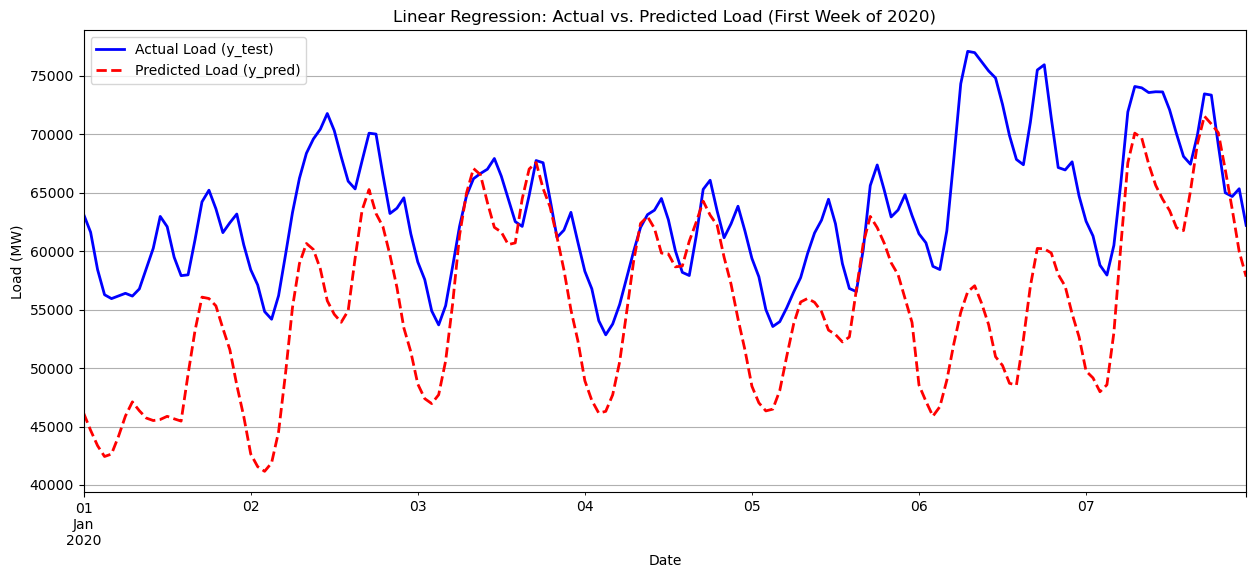

In [20]:
# --- 5. Visualize Predictions vs. Actuals ---

# Create a new DataFrame to hold the test results
df_results = pd.DataFrame({
    'Actual_Load': y_test,
    'Predicted_Load': y_pred_lr
})

# Set the index from y_test (which is the datetime index)
df_results.index = y_test.index

# Plot the first week of 2020 (168 hours)
df_results_sample = df_results.iloc[:168]

print("\nPlotting first week of 2020 predictions...")
plt.figure(figsize=(15, 6))

df_results_sample['Actual_Load'].plot(
    label='Actual Load (y_test)', 
    color='blue', 
    linewidth=2
)
df_results_sample['Predicted_Load'].plot(
    label='Predicted Load (y_pred)', 
    color='red', 
    linestyle='--', 
    linewidth=2
)

plt.title('Linear Regression: Actual vs. Predicted Load (First Week of 2020)')
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# --- 6. Train Advanced Model: Random Forest ---

# Create an instance of the model
# n_estimators=100 means we will build 100 'decision trees'
# random_state=42 ensures you get the same results every time you run it
# n_jobs=-1 uses all your computer's CPU cores to speed up the training
model_rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

# Train the model
print("Training the Random Forest model... (This may take a few minutes)")
model_rf.fit(X_train, y_train)
print("Model trained successfully.")

# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model's performance
print("\n--- Model Evaluation (Random Forest) ---")
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Absolute Error (MAE): {mae_rf:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f} MW")
print(f"R-squared (R²) Score: {r2_rf:.4f}")

Training the Random Forest model... (This may take a few minutes)



Plotting first week of 2020 predictions (Random Forest)...


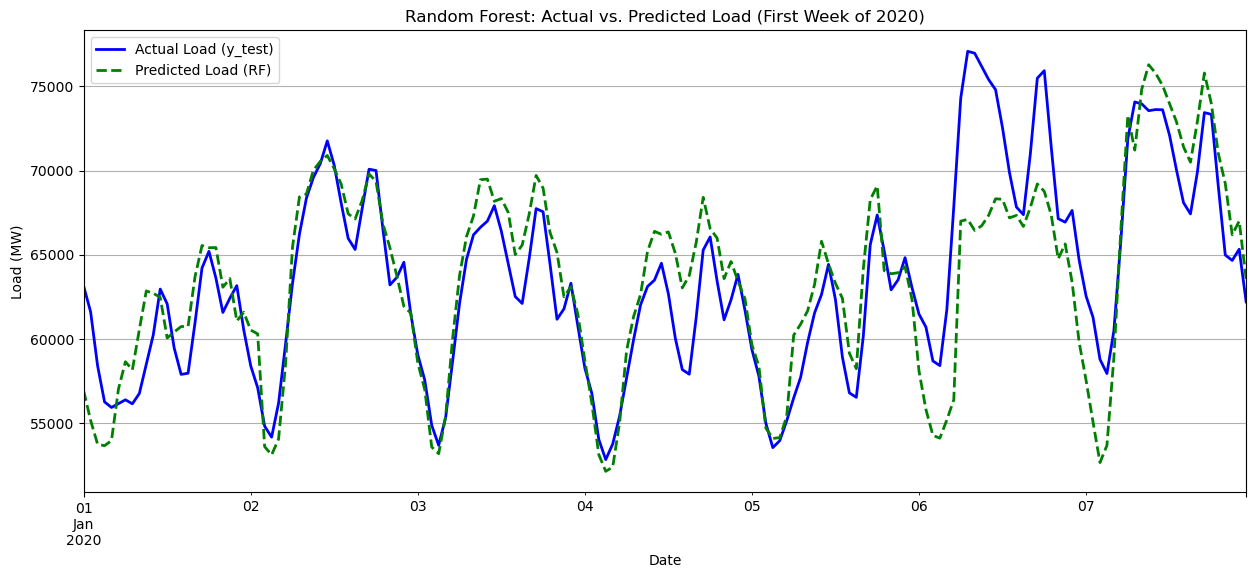

In [22]:
# --- 7. Visualize Predictions (Random Forest) ---

# Create a DataFrame to compare results
df_results_rf = pd.DataFrame({
    'Actual_Load': y_test,
    'Predicted_Load': y_pred_rf
})
df_results_rf.index = y_test.index

# Plot the first week of 2020
df_results_rf_sample = df_results_rf.iloc[:168]

print("\nPlotting first week of 2020 predictions (Random Forest)...")
plt.figure(figsize=(15, 6))

df_results_rf_sample['Actual_Load'].plot(
    label='Actual Load (y_test)', 
    color='blue', 
    linewidth=2
)
df_results_rf_sample['Predicted_Load'].plot(
    label='Predicted Load (RF)', 
    color='green', 
    linestyle='--', 
    linewidth=2
)

plt.title('Random Forest: Actual vs. Predicted Load (First Week of 2020)')
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

--- Top 10 Most Important Features ---
                               Feature  Importance
0   AT_load_actual_entsoe_transparency    0.335731
22                               month    0.319027
17  RO_load_actual_entsoe_transparency    0.141530
6   ES_load_actual_entsoe_transparency    0.059398
3   DE_load_actual_entsoe_transparency    0.032888
20                                hour    0.024368
11  DK_load_actual_entsoe_transparency    0.010493
23                                year    0.009218
10   FR_wind_onshore_generation_actual    0.008599
5            DE_wind_generation_actual    0.007325


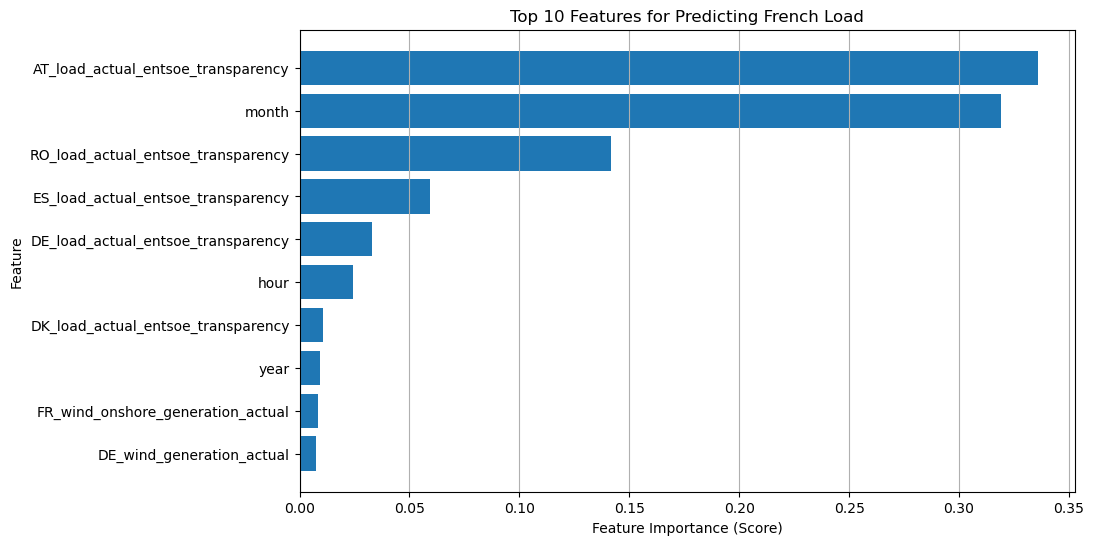

In [23]:
# --- 8. Feature Importance Analysis ---

# 1. Get the feature importances from the trained model
importances = model_rf.feature_importances_
feature_names = X.columns

# 3. Create a DataFrame to view them clearly
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Sort the DataFrame to see the most important features first
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# 5. Print the top 10
print("--- Top 10 Most Important Features ---")
print(importance_df_sorted.head(10))

# --- Plot the results (Top 10) ---
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df_sorted['Feature'].head(10), 
    importance_df_sorted['Importance'].head(10)
)
plt.xlabel("Feature Importance (Score)")
plt.ylabel("Feature")
plt.title("Top 10 Features for Predicting French Load")
plt.gca().invert_yaxis() 
plt.grid(True, axis='x')
plt.show()

In [24]:
# --- 9. Model Comparison Summary ---

# Create a dictionary
comparison_data = {
    'R² Score': [r2, r2_rf],
    'MAE (MW)': [mae, mae_rf],
    'RMSE (MW)': [rmse, rmse_rf]
}

# Create a DataFrame
df_comparison = pd.DataFrame(
    comparison_data, 
    index=['1. Baseline (Linear Regression)', '2. Advanced (Random Forest)']
)

# Print the final comparison table
print("--- Final Model Comparison ---")
print(df_comparison.round(4))

# Print a summary of the improvement
r2_improvement = r2_rf - r2
mae_reduction = mae - mae_rf

print("\n--- Summary of Improvement (RF vs Baseline) ---")
print(f"R² Score Improvement: +{r2_improvement:.4f}")
print(f"Mean Error (MAE) Reduction: -{mae_reduction:.2f} MW")

--- Final Model Comparison ---
                                 R² Score   MAE (MW)  RMSE (MW)
1. Baseline (Linear Regression)    0.7732  4052.5834  5135.0038
2. Advanced (Random Forest)        0.8942  2635.8802  3506.8951

--- Summary of Improvement (RF vs Baseline) ---
R² Score Improvement: +0.1210
Mean Error (MAE) Reduction: -1416.70 MW


In [13]:
from sklearn.model_selection import RandomizedSearchCV

# --- 10. Hyperparameter Tuning ---

print("Starting Hyperparameter Tuning...")
print("This WILL BE VERY LONG (30-60+ minutes).")

# Define the 'grid' of parameters to try
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees
    'max_depth': [10, 20, 30, None], # How deep the trees can be
    'min_samples_split': [2, 5, 10],   # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]      # Min samples at a leaf node
}

# Create the RandomizedSearch object
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid, 
    n_iter=10,  # <-- 10 random combinations
    cv=3,       # <-- 3-fold cross-validation
    verbose=2,  # <-- This will print the "validators"
    random_state=42, 
    n_jobs=-1 
)

# Fit the search
random_search.fit(X_train, y_train)

# Print the best parameters found
print("\n--- Tuning Complete ---")
print("The best parameters found are:")
print(random_search.best_params_)

Starting Hyperparameter Tuning (Full Version)...
This WILL BE VERY LONG (30-60+ minutes).
Look for lines starting with '[CV] START...' as 'validators'.
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Tuning Complete ---
The best parameters found are:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}


In [27]:
# --- 11. Evaluate the 'Best' Tuned Model ---

# Get the best model found by the search
model_best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred_best_rf = model_best_rf.predict(X_test)

# Evaluate the new model's performance
print("\n--- Model Evaluation (Tuned Random Forest - Long Search) ---")
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Mean Absolute Error (MAE): {mae_best_rf:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_best_rf:.2f} MW")
print(f"R-squared (R²) Score: {r2_best_rf:.4f}")


--- Model Evaluation (Tuned Random Forest - Long Search) ---
Mean Absolute Error (MAE): 2594.69 MW
Root Mean Squared Error (RMSE): 3458.55 MW
R-squared (R²) Score: 0.8971


In [ ]:
# --- 12. Final Model Comparison ---

# Create a dictionary with the results from all 3 models
comparison_data_final = {
    'R² Score': [r2, r2_rf, r2_best_rf],
    'MAE (MW)': [mae, mae_rf, mae_best_rf],
    'RMSE (MW)': [rmse, rmse_rf, rmse_best_rf]
}

# Create the final DataFrame
df_comparison_final = pd.DataFrame(
    comparison_data_final, 
    index=[
        '1. Baseline (Linear Regression)', 
        '2. Advanced (Random Forest)',
        '3. Tuned (Random Forest - Long)'
    ]
)

# Print the final comparison table
print("--- Final Model Comparison (All Models) ---")
print(df_comparison_final.round(4))